# Optimizers and Optimizer Tweaks

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from utilities.imports import *

### Typical Setup procedure

In [3]:
dataset_path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
transforms = [make_rgb, ResizedFixed(128), to_byte_tensor, to_float_tensor]
bs=128
loss_function = F.cross_entropy
num_filters = [32,64,128,256]
num_channels =3
num_categories = 10
callback_funcs = [partial(AvgStatsCallback, accuracy), CudaCallback, partial(IndependentVarBatchTransformCallback, normalize_imagenette)]
image_list = ImageList.from_files(dataset_path, tfms=transforms)
split_data = SplitData.split_by_function(image_list, partial(grandparent_splitter, valid_name="val"))
labeled_data = label_by_func(split_data, parent_labeler, proc_y=CategoryProcessor())
train_dl = torch.utils.data.DataLoader(labeled_data.train, bs, shuffle = True)
valid_dl = torch.utils.data.DataLoader(labeled_data.valid, bs*2, shuffle = False)

In [4]:
# model,runner = get_model_runner(num_filters, num_channels, num_categories, train_dl, valid_dl, 0.2, conv_layer, cbs_in=callback_funcs)
# optimizer = optim.SGD(model.parameters(), lr=0.9)

In [5]:
# runner.fit(1, model, optimizer, loss_function, train_dl, valid_dl)

## Optimizer Class: Generalizing torch.optim

In [6]:
#monkey patched in
def _update(os, dest, func):
    for o in os:
        for k,v in func(o).items():
            if k not in dest: #update if missing from destination
                dest[k] = v
def get_defaults(d): return getattr(d,'_defaults',{})

In [26]:
class Optimizer():
    def __init__(self, parameters, steppers, **defaults):
        self.steppers = convert_to_list(steppers)
        _update(self.steppers, defaults, get_defaults)
        self.param_groups = list(parameters) #each p_g has its own set of hyperparameters
        #ensure parameter groups are a list of a list of parameters
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups] #dictionary to store all hyper parameters, per p_g
    
    #goes through each parameter, in every parameter group
    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]#return all valid gradients
    
    def zero_grad(self):
        for param,hyperparam in self.grad_params():
            param.grad.detach_() #remove from computational graph
            param.grad.zero_() #zero out
            
    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

#### Basic SGD Stepper Function: Performs 1 step of the SGD

In [27]:
def sgd_stepper(param, learning_rate, **kwargs):
    param.data.add_(-learning_rate, param.grad.data)
    return param
sgd_optimizer = partial(Optimizer, steppers=[sgd_stepper])

In [28]:
schedule = combine_schedules([0.3, 0.7], [cosine_scheduler(0.3, 0.6), cosine_scheduler(0.6, 0.2)])
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'learning_rate', schedule)]
model,runner = get_model_runner(num_filters, num_channels, num_categories, train_dl, valid_dl, conv_layer, cbs_in=cbfs)
# new_sgd_opt = sgd_optimizer(model.parameters(), learning_rate=0.4)
# model_summary(runner, model, valid_dl)

In [29]:
runner.fit(1, model, sgd_optimizer(model.parameters()), F.cross_entropy, train_dl, valid_dl)

train: [1.7869385874300348, tensor(0.3868, device='cuda:0')]
valid: [1.368134205812102, tensor(0.5394, device='cuda:0')]


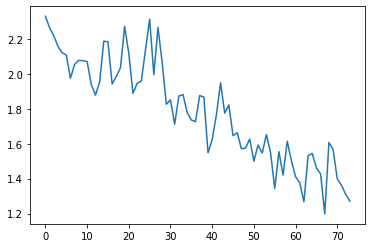

In [30]:
runner.recorder.plot_loss()

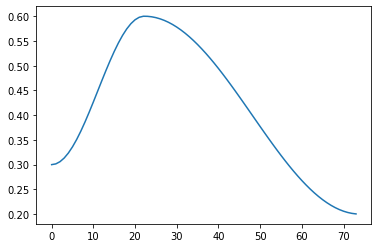

In [31]:
runner.recorder.plot_lr() #show off that 30/70 cosine annealing

## Weight Decay:
- Either Update the Loss itself or the gradients of the weights (aka the derivative)
- Good ole L2 Regularization

In [152]:
def weight_decay_stepper(param, learning_rate, weight_decay, **kwargs):
    _defaults = dict(weight_decay=0.)
    param.data.mul_(1 - learning_rate * weight_decay)
    return param
weight_decay_stepper._defaults = dict(weight_decay=0.) #explicit defaults

def l2_regularization_stepper(param, learning_rate, weight_decay, **kwargs):
    param.grad.data.add_(weight_decay, param.data)
    return param
l2_regularization_stepper._defaults = dict(weight_decay=0.) #explicit defaults

In [153]:
schedule = combine_schedules([0.3, 0.7], [cosine_scheduler(0.3, 0.6), cosine_scheduler(0.6, 0.2)])
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder]
wd_opt = partial(Optimizer, steppers=[weight_decay_stepper, sgd_stepper])
model,runner = get_model_runner(num_filters, num_channels, num_categories, train_dl, valid_dl, conv_layer, cbs_in=cbfs)
wd_optimizer = wd_opt(model.parameters(), learning_rate=0.1, weight_decay=0.01)

In [154]:
runner.fit(5, model, wd_optimizer,F.cross_entropy, train_dl, valid_dl)

train: [1.9078246283926497, tensor(0.3346, device='cuda:0')]
valid: [1.774520426950637, tensor(0.3934, device='cuda:0')]
train: [1.496785460284877, tensor(0.4973, device='cuda:0')]
valid: [1.836519829816879, tensor(0.3506, device='cuda:0')]
train: [1.3074346428147112, tensor(0.5694, device='cuda:0')]
valid: [1.704219247611465, tensor(0.4252, device='cuda:0')]
train: [1.1395637656431514, tensor(0.6334, device='cuda:0')]
valid: [1.3596352507961784, tensor(0.5546, device='cuda:0')]
train: [1.0375736779226952, tensor(0.6711, device='cuda:0')]
valid: [1.563521720740446, tensor(0.4596, device='cuda:0')]


## Momentum

In [155]:
class StateOptimizer(Optimizer):
    def __init__(self, params, steppers, stats = None, **defaults):
        self.stats = convert_to_list(stats)
        _update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {} #empty dict to track state
    
    def step(self):
        for param, hyper in self.grad_params():
            if param not in self.state:
                self.state[param] = {} #initalize the state, by parameter, if not present
                _update(self.stats, self.state[param], lambda o: o.init_state(param))
            state = self.state[param]
            for stat in self.stats: #update the state
                state = stat.update(param, state, **hyper)
            compose(param, self.steppers, **state, **hyper) #recompose stepper functions
            self.state[param] = state
        
class Stats():
    _defaults = {}
    def init_state(self, param): raise NotImplementedError #initalize state of the state
    def update(self, param, state, **kwargs): raise NotImplementedError #update stat's state
        
#average gradient state
class AverageGradient(Stats):
    _defaults = dict(momentum=0.9)    
    def init_state(self, param):
        return {'gradient_avg': torch.zeros_like(param.grad.data)}
    
    def update(self, param, state, momentum, **kwargs):
        state['gradient_avg'].mul_(momentum).add_(param.grad.data)
        return state

In [156]:
def momentum_stepper(p, learning_rate, gradient_avg, **kwargs):
    p.data.add_(-learning_rate, gradient_avg) #update with learning rate * gradient_avg
    return p

In [157]:
sgd_mom_opt = partial(StateOptimizer, steppers=[momentum_stepper,weight_decay_stepper],
                  stats=AverageGradient(), weight_decay=0.01)

In [158]:
model,runner = get_model_runner(num_filters, num_channels, num_categories, train_dl, valid_dl, conv_layer, cbs_in=cbfs)
mom_optimizer = sgd_mom_opt(model.parameters(), learning_rate=0.3)

In [159]:
runner.fit(1, model, mom_optimizer, F.cross_entropy, train_dl, valid_dl)

train: [2.0434664678820362, tensor(0.3282, device='cuda:0')]
valid: [2.8805722531847135, tensor(0.1913, device='cuda:0')]


## Adam & Adam Variants

Dampened Dibiased Momentum / Dampened Dibiased Root Sum of Squared Gradients

#### Adding Dampening and Squaring to the Average Gradient

In [52]:
# class AverageGradient(Stats):
#     _defaults = dict(mom=0.9)
    
#     def __init__(self, dampening:bool=False, squaring:bool=False): 
#         self.dampening=dampening
#         self.squaring = squaring
#         if squaring: _defaults = dict(mom=.99)
#     def init_state(self, p):
#         if not self.squaring:
#             return {'gradient_avg': torch.zeros_like(p.grad.data)}
#         else:
#             return {'sqr_gradient_avg': torch.zeros_like(p.grad.data)}
#     def update(self, p, state, mom, **kwargs):
#         if not self.squaring:
#             state['momentum_damp'] = 1-mom if self.dampening else 1.
#             state['gradient_avg'].mul_(mom).add_(state['momentum_damp'], p.grad.data)
#         else:
#             state['sqr_momentum_damp'] = 1-mom if self.dampening else 1.
#             state['sqr_gradient_avg'].mul_(mom).addcmul_(state['sqr_momentum_damp'], p.grad.data, p.grad.data) #squaring the gradients
#         return state
class AverageGrad(Stats):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state
class AverageSqrGrad(Stats):
    _defaults = dict(sqr_mom=0.99)

    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state   
class CountSteps(Stats):
    def init_state(self, p): return {'step_count': 0}
    def update(self, p, state, **kwargs):
        state['step_count'] += 1
        return state

In [53]:
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [164]:
def adam_stepper(p, learning_rate, mom, mom_damp, step_count, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
#     adam_stepper._defaults = dict(eps=1e-5)
    debias1 = debias(mom,     mom_damp, step_count)
    debias2 = debias(sqr_mom, sqr_damp, step_count)
    p.data.addcdiv_(-learning_rate / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_stepper._defaults = dict(eps=1e-5)


In [165]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StateOptimizer, steppers=[adam_stepper, weight_decay_stepper]+convert_to_list(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), CountSteps()], **kwargs)

In [166]:
adam_opt_func = adam_opt()
model,runner = get_model_runner(num_filters, num_channels, num_categories, train_dl, valid_dl, conv_layer, cbs_in=cbfs)
adam_optimizer = adam_opt_func(model.parameters(), learning_rate = 0.001)

In [167]:
runner.fit(3, model, adam_optimizer, F.cross_entropy, train_dl, valid_dl)

TypeError: adam_stepper() missing 1 required positional argument: 'eps'

# 
# [LAMB](https://arxiv.org/pdf/1904.00962.pdf)

In [131]:
def lamb_step(p, learning_rate, mom, mom_damp, step_count, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, weight_decay, **kwargs):
    debias1 = debias(mom,     mom_damp, step_count)
    debias2 = debias(sqr_mom, sqr_damp, step_count)
    r1 = p.data.pow(2).mean().sqrt()
    step_count = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + weight_decay*p.data
    r2 = step_count.pow(2).mean().sqrt()
    p.data.add_((-learning_rate * min(r1/r2,10)), step_count)
    return p
lamb_step._defaults = dict(eps=1e-6, weight_decay=0.)

In [132]:
lamb = partial(StateOptimizer, steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), CountSteps()])
model,run = get_model_runner(num_filters, num_channels, num_categories, train_dl, valid_dl, conv_layer, cbs_in=cbfs)
lamb_optimizer = lamb(model.parameters(), learning_rate=0.003)

In [133]:
runner.fit(3, model, lamb_optimizer, F.cross_entropy, train_dl, valid_dl)

train: [1.8567218109752879, tensor(0.3523, device='cuda:0')]
valid: [1.6155681478901274, tensor(0.4499, device='cuda:0')]
train: [1.3570890661302673, tensor(0.5501, device='cuda:0')]
valid: [1.441875, tensor(0.5136, device='cuda:0')]
train: [1.058099744891224, tensor(0.6565, device='cuda:0')]
valid: [1.3522806777468153, tensor(0.5674, device='cuda:0')]


## Other Optimizations 

- [Adaptive Gradient Methods with Dynamic Bound of Learning Rate](https://arxiv.org/abs/1902.09843)

- [Adafactor: Adaptive Learning Rates with Sublinear Memory Cost](https://arxiv.org/abs/1804.04235)

- [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888)